In [282]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest # RFECV, 
from sklearn.metrics import r2_score, root_mean_squared_error, root_mean_squared_log_error
from sklearn import set_config
from FunctionsML import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

# Loading Data
- The data is from a Kaggle competition and contains 80 metrics describing housing prices
- The SalePrice is the target feature and should be forcast via a supervised Machine Learning
  Algorithm

In [38]:
df = pd.read_csv('Data/housing_iteration_6_regression.csv')
df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1434,1435,20,RL,80.0,17400,Pave,NaN,Reg,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1977,1977,Gable,CompShg,BrkFace,BrkFace,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,936,Unf,0,190,1126,GasA,Fa,Y,SBrkr,1126,0,0,1126,1,0,2,0,3,1,TA,5,Typ,1,Gd,Attchd,1977.0,RFn,2,484,TA,TA,P,295,41,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,160000
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
471,472,60,RL,92.0,11952,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,2Story,7,6,1977,1977,Mansard,WdShake,WdShing,Plywood,NaN,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,808,808,GasA,TA,Y,SBrkr,1161,808,0,1969,0,0,2,1,3,1,TA,8,Typ,1,Gd,Attchd,1977.0,RFn,2,534,TA,TA,Y,0,0,0,0,276,0,NaN,NaN,NaN,0,11,2007,WD,Normal,190000
1369,1370,20,RL,48.0,10635,Pave,NaN,IR2,Lvl,AllPub,FR2,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,171.0,Gd,TA,PConc,Gd,TA,Av,BLQ,370,GLQ,972,315,1657,GasA,Ex,Y,SBrkr,1668,0,0,1668,1,0,2,0,3,1,Gd,8,Typ,1,TA,Attchd,2003.0,Fin,2,502,TA,TA,Y,0,262,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,232000
485,486,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1950,2007,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,607,Unf,0,506,1113,GasA,Gd,Y,SBrkr,1113,0,0,1113,0,0,1,0,3,1,Gd,5,Typ,1,Gd,Attchd,1950.0,Unf,1,264,TA,TA,Y,0,80,120,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal,147000


# Data Cleaning

In [40]:
# get rid of 10 strange entries in MSZoning
df.loc[df['MSZoning'] == 'C (all)','MSZoning'] = 'NA'

# Preprocessing
- First, a test train split is performed (**X_train, X_test, y_train, y_test**),
  20% of the data is used as test data to reduce and test overfitting
- Numerical and categorical features are split (**X_cat, X_num**)
- 1.1) Numerical Pipe
  The numerical data is treated with a SimpleImputer to get rid of NaNs,
  if imputing the mean or median values is tested later, **numerical_pipe**
- 1.2) Categorical Pipe
  - The ordinal categorical data is transformed with an ordinal encoder and
    the remaining data with an one-hot encoder, the whole CollumnTransformer is
    called **cat_encoder**
  - The categorical data is treated with a SimpleImputer as well
  - The cat_encoder and the SimpleImputer form the **categoric_pipe**
- 1.3) The numerical_pipe and the categoric_pipe form the **preprocessor**

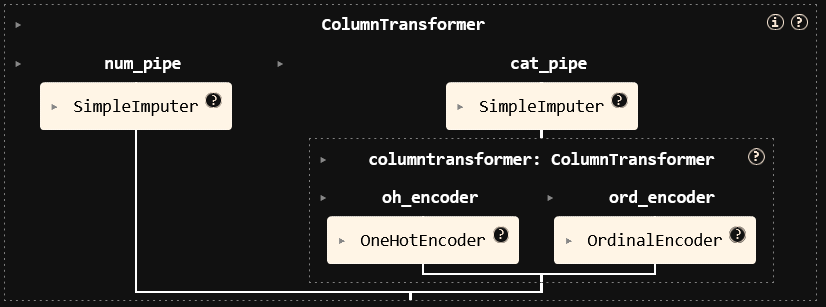
  
  

In [43]:
# creating a dataframe to save scores
scores=pd.DataFrame(columns=['neg_root_mean_squared_log_error','R2','RSME'])

# seperate prediction- and target features
X = df.copy() # prediction features
X = X.set_index('Id') # the ID is used as index
y = X.pop('SalePrice') # target features

# perform the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1230)

# 1) Built Preprocessor
# seperate categorical and numerical data
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 1.1) create numerical pipeline, only with the SimpleImputer, the strategy is scanned later
numeric_pipe = make_pipeline(
    SimpleImputer()
)

In [45]:
# 1.2) create categorical pipeline

# Setting up the ordinal encoder
set_config(transform_output='pandas')
# define ordinal features
ord_feat = ['ExterQual',
            'ExterCond',
            'MSZoning',  
            'LotShape',  
            'Utilities', 
            'LandSlope', 
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure', 
            'BsmtFinType1',
            'BsmtFinType2', 
            'HeatingQC',
            'CentralAir', 
            'KitchenQual',
            'FireplaceQu',
            'GarageFinish',
            'GarageQual',
            'GarageCond', 
            'PavedDrive',
            'PoolQC',
            'Fence']

# Create ordered categories of all features
# All orders must include the cat_imputer's fill_value so missing values can be encoded
ex_to_po = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

# Category orders for each ordinal feature
ExterQual = ex_to_po
ExterCond = ex_to_po
MSZoning = ['FV','RL','RP','RH','RM','C','A', 'I', 'NA']
LotShape = ['IR3','IR2','IR1','Reg','NA']
Utilities = ['AllPub','NoSewr','NoSeWa','ELO','NA']
LandSlope = ['Sev','Mod','Gtl','NA']
BsmtQual = ex_to_po
BsmtCond = ex_to_po
BsmtExposure = ['Gd', 'Av', 'Mn', 'No', 'NA']     
BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC = ex_to_po
CentralAir = ['Y','N','NA']
KitchenQual = ex_to_po
FireplaceQu = ex_to_po
GarageFinish =['Fin','RFn','Unf','NA']
GarageQual = ex_to_po
GarageCond = ex_to_po
PavedDrive =['Y', 'P', 'N', 'NA']
PoolQC = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
Fence = ['GdPrv','MnPrv','GdWo','MnWw','NA']

# List of all orders
category_orders = [ExterQual,
                   ExterCond,
                   MSZoning,  
                   LotShape, 
                   Utilities, 
                   LandSlope,  
                   BsmtQual,
                   BsmtCond,
                   BsmtExposure,
                   BsmtFinType1,
                   BsmtFinType2, 
                   HeatingQC,
                   CentralAir,
                   KitchenQual,
                   FireplaceQu,
                   GarageFinish,
                   GarageQual,
                   GarageCond, 
                   PavedDrive, 
                   PoolQC,
                   Fence]

# Initializing ordinal encoder
ord_encoder = OrdinalEncoder(categories=category_orders)


# Defining all remaining features to be treated with a one-hot encoder
oh_feat = list(set(X_cat)-set(ord_feat)) # one hot features

# Initializing one-hot encoder
oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', # min_frequency determined in grid
                           sparse_output=False) # must be false now that we've set_config to pandas

# full categorical encoder 
cat_encoder = ColumnTransformer(
    transformers=[
    ('oh_encoder', oh_encoder, oh_feat),
    ('ord_encoder', ord_encoder, ord_feat)
    ], verbose_feature_names_out=False) # this is for plotting the tree

In [47]:
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") 
# and the OneHotEncoder

categoric_pipe = make_pipeline(
                SimpleImputer(fill_value="NA"),  # fill missing data with 'NA'
                cat_encoder
)

# initialize the make_column_transformer to split into branches
preprocessor = ColumnTransformer(
    transformers=[
    ('num_pipe', numeric_pipe, X_num.columns),
    ('cat_pipe', categoric_pipe, X_cat.columns),
    ]
)

In [49]:
# # make a report to get an overview of the data
# from ydata_profiling import ProfileReport 	
# report = ProfileReport(pd.concat([X_train,y_train],axis=1)) 	
# report.to_file('report_regression.html')

# Different Algorithms
- Regression performance is tested with different algorithms
  Decision tree, Random Forest
- The hyperparameter space is always tested with a 5-fold Cross Validation
  using GridSearchCV.  For scoring 'neg_root_mean_squared_log_error'
  is used, as this is the parameter scanned for in the Kaggle competition
- The parameter grid used, is the result of thorough parameter testing, the
  starting parameters are left in the code.

## Decision tree
- Decision tree with the preprocessor

 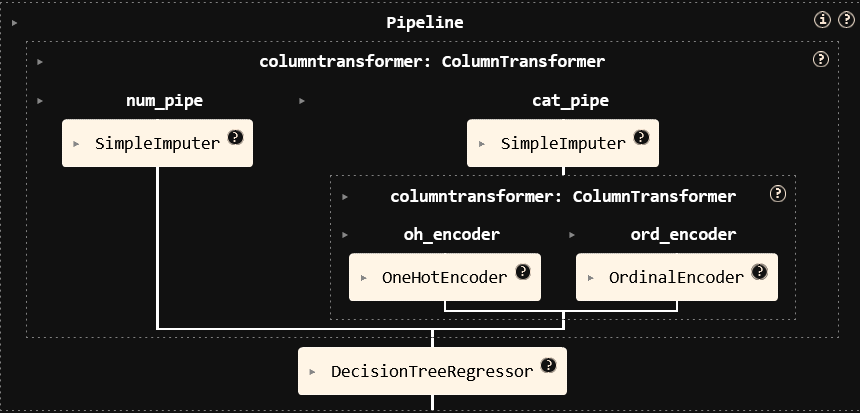

In [53]:
# import DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor
from numpy import arange # this allows you to make ranges with floats

# create full pipeline with the preprocessor and the decision tree
dt_pipe = make_pipeline(preprocessor,
                            DecisionTreeRegressor(random_state=123))


In [444]:
# Defining the cross validation

# good start: 
# dt_param_grid = {
#     'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'decisiontreeregressor__max_depth': range(2, 15, 2),  
#     'decisiontreeregressor__min_samples_leaf': range(5,30,3), 
#     'decisiontreeregressor__min_impurity_decrease':arange(0.1, 0.5, 0.2), 
#     'decisiontreeregressor__ccp_alpha':[10**e for e in range(-4, 0)] + [0] 
# }

dt_param_grid = {
    'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], 
    'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'], 
    'decisiontreeregressor__max_depth': range(13, 16, 1), 
    'decisiontreeregressor__min_samples_leaf': range(13,16,1), 
    'decisiontreeregressor__min_impurity_decrease':arange(0.1, 0.5, 0.1),  
    'decisiontreeregressor__ccp_alpha': [0] + [10**e for e in range(-7, -4)]
}

# Initalize the GridSearch
dt_search = GridSearchCV(dt_pipe, # you have defined this beforehand
                      dt_param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='neg_root_mean_squared_log_error', # the performance metric to use,
                      n_jobs=-1, # uses all CPU cores, slows down other applications
                      verbose=1) # controls output

# Fit your parameter grid to the training data, %time stops time
%time dt_search.fit(X_train, y_train)

# Use model to predict training data
dt_r2 = r2_score(y_train, dt_search.predict(X_train))
print('The r2_score for the training data is: ', round(dt_r2,2))
dt_rmse = root_mean_squared_error(y_train, dt_search.predict(X_train))
print('The rmse for the training data is: ', round(dt_rmse,2))
# best parameters
print('The best parameters are: ')
dt_search.best_params_

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits
CPU times: total: 3min 39s
Wall time: 6min 51s
The r2_score for the training data is:  0.86
The rmse for the training data is:  29710.6
The best parameters are: 


{'columntransformer__cat_pipe__simpleimputer__strategy': 'most_frequent',
 'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'decisiontreeregressor__ccp_alpha': 0,
 'decisiontreeregressor__max_depth': 12,
 'decisiontreeregressor__min_impurity_decrease': 0.1,
 'decisiontreeregressor__min_samples_leaf': 14}

In [435]:
# Use model to predict testing data
dt_score = root_mean_squared_error(y_test, dt_search.predict(X_test))
print('The rsme for the testing data is: ', round(dt_score,2))

# save score to dictionary
scores['DecisionTree'] = dt_score

The rsme for the testing data is:  36537.86


## K nearest neighbours
* requires scaling
* highly sensitve to feature selection
* slow prediction, fast fitting
* Principal component analysis can be implemented into the pipeline

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'standardscaler': As the KNN regressor needs scaling, different scaling methods are tested,
  the standard and the robust scaler are found to be most promising
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'knn': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [56]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

knn_pipe= Pipeline([('preprocessor',preprocessor),
                    ('standardscaler',StandardScaler()),
                    ('feature', 'passthrough'),#
                    ('pca','passthrough'), # PCA(), #PCA should be done after scaling
                    ('knn',KNeighborsRegressor()),
])
                            

In [ ]:
# History of parameter grids to show what was changes along the way

## good starting values and all options apart from the feature selection
# knn_param_grid = {
#     'columntransformer__cat_pipe__simpleimputer__strategy':['constant','most_frequent'],
#     'columntransformer__num_pipe__simpleimputer__strategy':['mean','median'],
#     'standardscaler': ['passthrough', StandardScaler(), RobustScaler(), MinMaxScaler()],   # possible scalers
#     'pca':['passthrough',PCA()],       # no PCA or PCA
#     'pca__n_components': range(3, 10),                                  

#     'kneighborsregressor__n_neighbors': range(3, 10),                    #  up to 50 for large datasets
#     'kneighborsregressor__weights': ['uniform','distance'],              
#     'kneighborsregressor__p':range(1,5,1)                                
# }

# # param grid for feature selection with SelectFromModel using a Decision Tree
# knn_param_grid = {
#     'preprocessor__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], 
#     'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'standardscaler': [StandardScaler(), RobustScaler()], 
    
#     'feature':[SelectFromModel(DecisionTreeRegressor(random_state=123))],
    
#     'knn__n_neighbors': range(8,12,1),                   
#     'knn__weights': ['distance','uniform'],        
#     'knn__p': arange(1,2,0.5)
# }
# # param grid for SelectKBest, test f_regression and mutual_info_regression
# knn_param_grid = {
#     'preprocessor__cat_pipe__simpleimputer__strategy':['constant'],
#     'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
#     'standardscaler': [StandardScaler(), RobustScaler()],

#     'feature':[SelectKBest()], 
#     'feature__score_func': [f_regression, mutual_info_regression], 
#     'feature__k':range(15,17,1),

#     'knn__n_neighbors': range(12,15,1), 
#     'knn__weights': ['distance'],
#     'knn__p': arange(1.3,1.9,0.2)
# } 

In [379]:
# Training of the algorithm
# final param grid for SelectKBest with mutual_info_regression
knn_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['constant'], 
    'preprocessor__num_pipe__simpleimputer__strategy':['mean','median'], 
    'standardscaler': [StandardScaler(), RobustScaler()],  
    
    'feature':[SelectKBest()], 
    'feature__score_func': [mutual_info_regression], #
    'feature__k':range(16,22,1),
   
    'knn__n_neighbors': range(12,15,1),                   
    'knn__weights': ['distance'],             
    'knn__p': arange(1.2,1.6,0.1) 
}                                                                  
# initialiing the Cross Validation
knn_search = GridSearchCV(knn_pipe,
                          knn_param_grid,
                          cv=5,
                          scoring='neg_root_mean_squared_log_error',
                          verbose=1,
                          n_jobs=-1)

%time knn_search.fit(X_train, y_train)
# best parameters
print('The best score is: ', round(knn_search.best_score_,3))
# best parameters
print('The best parameters are: ')
knn_search.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
CPU times: total: 16.2 s
Wall time: 5min 38s
The best score is:  -0.163
The best parameters are: 


{'feature': SelectKBest(),
 'feature__k': 17,
 'feature__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'knn__n_neighbors': 12,
 'knn__p': 1.2,
 'knn__weights': 'distance',
 'preprocessor__cat_pipe__simpleimputer__strategy': 'constant',
 'preprocessor__num_pipe__simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [382]:
# show best parameters
test = show_best(knn_search,25)
print('the result is:', test['mean_test_score'].mean(), '+-' , test['mean_test_score'].std())

the result is: -0.1643257956727635 +- 0.000383481090820969


In [290]:
# Use model to predict testing data
knn_score = root_mean_squared_error(y_test, knn_search.predict(X_test))
print('The rsme for the testing data is: ', round(knn_score,2))
knn_score = r2_score(y_test, knn_search.predict(X_test))
print('The r2 for the testing data is: ', round(knn_score,2))
# save score to dictionary
scores['Knn'] = knn_score

The rsme for the testing data is:  31685.85
The r2 for the testing data is:  0.85


In [292]:
# find the most important parameters
knn_search.best_estimator_.named_steps['knn'].feature_names_in_

array(['num_pipe__OverallQual', 'num_pipe__YearBuilt',
       'num_pipe__YearRemodAdd', 'num_pipe__TotalBsmtSF',
       'num_pipe__1stFlrSF', 'num_pipe__GrLivArea', 'num_pipe__FullBath',
       'num_pipe__TotRmsAbvGrd', 'num_pipe__GarageCars',
       'num_pipe__GarageArea', 'cat_pipe__ExterQual',
       'cat_pipe__BsmtQual', 'cat_pipe__KitchenQual',
       'cat_pipe__FireplaceQu', 'cat_pipe__GarageFinish'], dtype=object)

## Random Forest
* tradeoff between performance vs training time (start with few fits)
* robust to overfitting
* no scaling needed
* Random forests benefit from feature selection but can still tolerate high numbers of features.
  Unlike KNN, features that only have a little information can still be utilized by random forests.

**The Pipeline**
<br>After the preprocessing different methods are tested:
- 'feature': feature selection checks for import features and reduces the dimensionality
   of the dataset, different methods are probed:
    - SelectFromModel(DecisionTreeRegressor), which uses a Decision Tree for feature selection
    - SelectKBest(f_regression or mutual_info_regression), which uses statistical methods
       
- 'rf': the number of neighbors, the weights (uniform: all neighbours equal/distance, closer
  neighbours more important) and the measuring distances p (manhattan or Euclidean distance)
  are tested

To show the process of finding the right parameters, parameter grids of the most important steps
are left in the code 

In [64]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe= Pipeline([('preprocessor',preprocessor),
                    ('feature', 'passthrough'), # for testing the scalers
                    ('rf', RandomForestRegressor()),
])

In [300]:
# Due to time constrains only a broad parameter search performed
                             
rf_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['constant'], # ,,'most_frequent'
    'preprocessor__num_pipe__simpleimputer__strategy':['median'], # 'mean','

    #'feature':[SelectFromModel(DecisionTreeRegressor(random_state=123))],
    'feature':[SelectKBest()], 
    'feature__score_func': [f_regression, mutual_info_regression], #
    'feature__k':range(16,22,1),
    #'feature':['passthrough'],

    'rf__n_estimators': range(130, 210, 30), 
    'rf__max_depth': [12,15,18],        #
    'rf__min_samples_leaf': [5],  #
    #'rf__ccp_alpha': arange(0., 0.01, 0.0025)#[10**e for e in range(-5, -1)]                #4 options
} 

rf_param_grid = {
    'preprocessor__cat_pipe__simpleimputer__strategy':['constant','most_frequent'], # ,
    'preprocessor__num_pipe__simpleimputer__strategy':['median','mean'], # ,'

    #'feature':[SelectFromModel(DecisionTreeRegressor(random_state=123))],
    #'feature':[SelectKBest()], 
    #'feature__score_func': [f_regression], # mutual_info_regression
    #'feature__k':range(20,22,1),
    #'feature':['passthrough'],

    'rf__n_estimators': range(100, 250, 50), 
    'rf__max_depth': [10,12,14,16,18,20],        #
    'rf__min_samples_leaf': [3,4,5],  #
    'rf__ccp_alpha': [10**e for e in range(-5, -1)] + [0]                #4 options
} 

rf_search = RandomizedSearchCV(rf_pipe,
                               rf_param_grid, 
                               n_iter = 100, 
                               cv = 5, 
                               scoring='neg_root_mean_squared_log_error',
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1)

# rf_search = GridSearchCV(rf_pipe,
#                          rf_param_grid,
#                          cv=5, 
#                          scoring='neg_root_mean_squared_log_error', #'neg_root_mean_squared_log_error',
#                          verbose=1,
#                          n_jobs=-1) # especially important for random forest

%time rf_search.fit(X_train, y_train)

# save scores
rf_score = {'neg_root_mean_squared_log_error':round(rf_search.best_score_,3),
         'R2':round(r2_score(y_train, rf_search.predict(X_train)),3),
         'RSME':round(root_mean_squared_error(y_train, rf_search.predict(X_train)),3)
}
# save scores
scores = pd.concat([scores, pd.DataFrame(rf_score,index=['rf_score'])])
scores


Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 5.89 s
Wall time: 1min 53s


,neg_root_mean_squared_log_error,R2,RSME
rf_score,-0.160,0.940,19196.632
rf_score,-0.148,0.955,16568.714


## Comparing
- The RF Algorithm is not optimized yet.  

Compare different algorithms so far:
<br>DecisionTree: RSME = 36537
<br>KNN: RSME = 31685, R2 = 0.85 
<br>Random Forest: RSME = 16568, R2 = 0.955 (training data)

My results (red) score average in the competition, further optimizing especially with the RF<br>
algorithm is needed. I want to test the XG boost regresssor as well. 

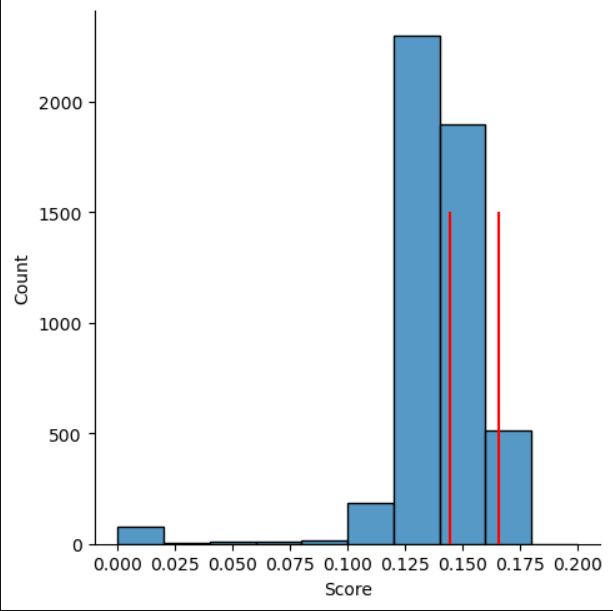